<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO
* Pass pca model back
* implement visualization of clusters

np.shape(np.unique(a, return_counts=False))[0]

#### Setup

In [2]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 31.7 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
     |████████████████████████████████| 61 kB 472 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import files
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
import pandas as pd
import random
import os
import numpy as np
import re
import numpy
import nltk
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import spacy
from collections import Counter
from joblib import Parallel, delayed
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import torch.nn as nn
from sklearn.decomposition import PCA
import time
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
#from sentence_transformers import SentenceTransformer

In [5]:
# Get BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Get GloVe
glove_file="/content/drive/MyDrive/Berkeley/INFO256/data/glove/glove.6B.100d.100K.txt"
glove_in_w2v_format="/content/drive/MyDrive/Berkeley/INFO256/data/glove/glove.6B.100d.100K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)
glove = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Berkeley/INFO256/data/glove/glove.6B.100d.100K.w2v.txt", binary=False)

In [7]:
#glove['good']

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


# Functions: Preprocessing, BERT embedding, clustering

### Preprocessing

In [9]:
#def preprocess(df: pd.DataFrame, set_col_label):
#  df = df[df[set_col_label] != 'no description']
#  #df = df.drop(columns=['Unnamed: 0'])
#  #print(df.shape)
#  return df

In [10]:
# Merge personality descriptions onto data split df
def two_col(row): 
  text = str(row['personality_x']) + str(row['personality_y'])
  return text

def preprocess_long(df1, df2, df_split):
  # Clean df1
  df1 = df1_pers.copy()
  df1 = df1[df1['personality'].notnull()]
  df1 = df1[['film', 'protagonist', 'personality']]
  df1 = df1.rename(columns={'protagonist':'character'})

  # clean df2
  df2 = df2_pers.copy()
  df2 = df2.rename(columns={'character ':'character'})

  # Merge
  df_all = df_splits.merge(df1, on=['film', 'character'], how='outer')
  df_all = df_all.merge(df2, on=['film', 'character'], how='outer')
  df_all['personality_x'] = df_all['personality_x'].replace(np.nan, '')
  df_all['personality_y'] = df_all['personality_y'].replace(np.nan, '')
  df_all['personality'] = df_all.apply(lambda x: two_col(x) ,axis=1)
  df_all = df_all.drop(columns=['personality_x', 'personality_y'])
  print(df1_pers.shape, df2_pers.shape, df1.shape, df2.shape, df_all.shape, df_splits.shape)
  return df_all

#### BERT sequence embedding

In [11]:
# Function to get BERT sequence embedding
def get_cls_token_for_text(model, string):
    inputs = tokenizer(string, return_tensors="pt")

    outputs = model(**inputs)
    tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    last_hidden_states = outputs.last_hidden_state[0][1].detach().numpy()

    return last_hidden_states

In [12]:
# Get BERT sequence embedding for each personality description of character
def get_cls_token_for_df(model, df):
  df_cls = pd.DataFrame({})
  print(df.columns)

  for row in range(df.shape[0]):
    curr_cls = get_cls_token_for_text(model, df.loc[row, 'personality'])
    curr_df_cls = pd.DataFrame(curr_cls.reshape(-1, len(curr_cls)))
    df_cls = pd.concat([df_cls, curr_df_cls]).reset_index(drop=True)

  df_cls_final = pd.concat([df, df_cls], axis=1)
  return df_cls_final


#### Alternative embedding: GloVe

In [13]:
def get_relevant_adjectives(text: str):
  text = text.lower()
  
  # split
  text_list = text.split('personality...')
  if len(text_list) < 2:
    text_list = text.split('personality…')
  text_list = text_list[1].split('.')
  word_list = re.split("\s|(?<!\d)[,.](?!\d)", text_list[0].replace('-', ' '))

  # clean/remove
  word_list = [word.replace('\xa0', '') for word in word_list]
  word_list = [word for word in word_list if word!='']
  #print(word_list)
  return word_list

In [14]:
# Get GloVe embedding for one text
def get_glove_token_for_text(text: str):
  word_list = get_relevant_adjectives(text)
  glove_list = []

  for word in word_list:
    try:
      glove_list.append(glove[word])
    except: 
        pass

  glove_mean = np.mean(np.array(glove_list), axis=0)
  return glove_mean

In [15]:
#test = df_all.personality[0]
#test1 = get_glove_embedding_for_text(test)
#test1

In [16]:
# Get GloVe for all descriptions
def get_glove_token_for_df(df):
  df_glove = pd.DataFrame({})

  for row in range(df.shape[0]):
    curr_glove = get_glove_token_for_text(df.loc[row, 'personality'])
    curr_df_glove = pd.DataFrame(data=[curr_glove])
    df_glove = pd.concat([df_glove, curr_df_glove]).reset_index(drop=True)

  df_glove_final = pd.concat([df, df_glove], axis=1)
  df_glove_final = df_glove_final[df_glove_final[50].notnull()]
  return df_glove_final


In [17]:
def get_train_dev_test(df):
  df_train = df[df['set']=='train']
  df_dev = df[df['set']=='dev']
  df_test = df[df['set']=='test']
  return df_train, df_dev, df_test

## Clustering

### Clustering evaluations

In [18]:
def convert_df(df: pd.DataFrame):
  df_copy = df.copy()
  df_copy = df_copy.drop(columns=['Unnamed: 0', 'film', 'character', 'set', 'personality'])  
  return df_copy       

In [29]:
def evaluate_kmeans_for_k(k_vals: np.array, df: pd.DataFrame, model_choice, embedding, pca=False, n=3):
  inertia_list = []
  sil_score_list = []
  label_list = []
  kmean_model_list = []
  pca_model_list = []

  # PCA dimensionality reduction
  X = convert_df(df)
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  if pca == True:
    pca_model = PCA(n_components=n)
    X = pca_model.fit_transform(X)
    pca_model_list.append(pca_model)
    print(pca_model_list[0])

  # run kmeans
  for k in k_vals:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

    # Get metrics for k-means evaluation
    inertia_list.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_score_list.append(silhouette_score(X, labels, metric = 'euclidean')) 

    # Save model labels and fitted models
    label_list.append(labels)
    kmean_model_list.append(kmeans)

  draw_eval_plots(k_vals, inertia_list, sil_score_list, model_choice=model_choice, embedding=embedding)

  return label_list, kmean_model_list, X, pca_model_list

In [30]:
def evaluate_dbscans_for_e(eps_vals: np.array, df: pd.DataFrame, model_choice, embedding, pca=False, n=3, min_samples=5):
  cluster_list = []
  sil_score_list = []
  label_list = []
  dbscan_model_list = []
  pca_model_list = []

  # PCA dimensionality reduction
  X = convert_df(df)
  if pca == True:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca_model = PCA(n_components=n)
    X = pca_model.fit_transform(X)
    pca_model_list.append(pca_model)

  for e in eps_vals:
    print("eps value: ", e)
    dbscan = DBSCAN(eps=e, min_samples = min_samples).fit(X)


    # Get metrics for DBSCAN evaluation
    labels = dbscan.labels_
    no_cluster = np.shape(np.unique(labels, return_counts=False))[0]
    cluster_list.append(no_cluster)
    #labels = dbscan.fit_predict(X_scaled)
    sil_score_list.append(silhouette_score(X, labels, metric = 'euclidean')) 

    # Save model labels and fitted models
    label_list.append(labels)
    dbscan_model_list.append(dbscan)

  draw_eval_plots(eps_vals, cluster_list, sil_score_list, model_choice=model_choice, embedding=embedding)

  return label_list, dbscan_model_list, X, pca_model_list



In [31]:
def evaluate_models(df1, df2, df_split, embedding, model_choice, iter_vals, min_samples=5, pca=False, n=3):
  # Preprocess
  df_all = preprocess_long(df1, df2, df_split)

  if embedding=='bert':
    # BERT embedding
    df_embed = get_cls_token_for_df(model, df_all)
    
  if embedding=='glove':
    # GloVe embedding
    df_embed = get_glove_token_for_df(df_all)
    
  # Break up into train, dev, test
  df_train, df_dev, df_test = get_train_dev_test(df_embed)
  print(df_dev.shape, df_train.shape, df_test.shape)

  print("Running model ", model_choice, " with embedding ", embedding)
  if model_choice=='kmeans':
    # Run clustering with different k
    label_list, model_list, X, pca_model  = evaluate_kmeans_for_k(k_vals=iter_vals, df=df_train, pca=pca, n=n, model_choice=model_choice, embedding=embedding)

  if model_choice=='dbscan':
    label_list, model_list, X, pca_model  = evaluate_dbscans_for_e(eps_vals=iter_vals, df=df_train, min_samples=min_samples, pca=pca, n=n, model_choice=model_choice, embedding=embedding)

  return [df_train, df_dev, df_test], label_list, model_list, X, pca_model

In [42]:
def run_final_kmeans(model, df, pca_model, pca=False):
  X = convert_df(df)
  print(pca_model)
  if pca==True:
    X = pca_model[0].transform(X)
  
  labels = model.predict(X)
  sil_score = silhouette_score(X, labels, metric = 'euclidean')

  return labels, sil_score, X

### Visualizations

In [33]:
def draw_eval_plots(k_vals, inertia_dist_list, sil_score_list, model_choice, embedding):
  figure(figsize=(8,4), dpi=100)
  plt.plot(k_vals, inertia_dist_list, '-o', label=k_vals)
  plt.xlabel("k clusters / eps values")
  plt.ylabel("Inertia / SSE")
  for x,y in zip(k_vals,inertia_dist_list):
    plt.annotate(x, 
                (x,y), 
                textcoords="offset points", 
                xytext=(0,10),
                ha='center')
  if model_choice == 'kmeans':
    plt.ylabel("Inertia / SSE")
  else:
    plt.ylabel("Cluster #")
  plt.show()
  #path = '/content/drive/MyDrive/Berkeley/INFO256/data/plots/' + model_choice + '_' + embedding + '_inertia_cluser_no.png'
  #plt.savefig(path)

  figure(figsize=(8,4), dpi=100)
  plt.plot(k_vals, sil_score_list, '-o', label=k_vals)
  plt.xlabel("k clusters / eps values")
  plt.ylabel("Silhouette Score")
  for x,y in zip(k_vals, sil_score_list):
    plt.annotate(x, 
                (x,y), 
                textcoords="offset points", 
                xytext=(0,10),
                ha='center')
  #plt.show()
  #path = '/content/drive/MyDrive/Berkeley/INFO256/data/plots/' + model_choice + '_' + embedding + '_silhouette.png'
  return

In [47]:
def draw_cluster_plot(X, label_list):
  # dimensionality reduction for plotting
  pca = PCA(n_components=2)
  X = pca.fit_transform(X)

  # plot clusters
  x = X[:, 0]
  y = X[:, 1]
  cdict = {0: 'purple', 1: 'red', 2: 'blue', 3: 'green', 4: 'orange', 5:'magenta', 6:'black', -1:'grey', 7:'brown', 8:'cyan', 9:'cyan'}

  fig, ax = plt.subplots()
  for l in np.unique(label_list):
      ix = np.where(label_list == l)
      ax.scatter(x[ix], y[ix], c = cdict[l], label = l, s = 100)
  ax.legend()
  plt.show()

  return

In [35]:
from yellowbrick.cluster import SilhouetteVisualizer

def visualize_silhouette_plots(k_inspect_vals, model_list, label_list, X):
  for k in k_inspect_vals:
    curr_model = model_list[k]
    visualizer = SilhouetteVisualizer(curr_model, colors='yellowbrick')

    visualizer.fit(X)        
    visualizer.show() 
    draw_cluster_plot(X, label_list[k])
  return

# Run pipeline

#### Read data

In [26]:
# Read relevant csv
df1_pers = pd.read_csv('/content/drive/MyDrive/Berkeley/INFO256/data/character_tour_manual_part1_split.csv')
df_splits = pd.read_csv('/content/drive/MyDrive/Berkeley/INFO256/data/characters-test-train-dev.csv')
df2_pers = pd.read_csv('/content/drive/MyDrive/Berkeley/INFO256/data/additional characters.csv')
df2_pers.columns

Index(['film', 'character ', 'personality'], dtype='object')

In [27]:
df_splits.groupby(['set']).count()

,Unnamed: 0,film,character
set,,,
dev,40,40,40
test,40,40,40
train,184,184,184


### Run: kmeans without PCA
* BERT: k=2, silhouette score=0.122
* GloVe: k=2, silhouette score:0.19

(519, 7) (76, 3) (188, 3) (76, 3) (264, 5) (264, 4)
Index(['Unnamed: 0', 'film', 'character', 'set', 'personality'], dtype='object')
(40, 773) (184, 773) (40, 773)
Running model  kmeans  with embedding  bert


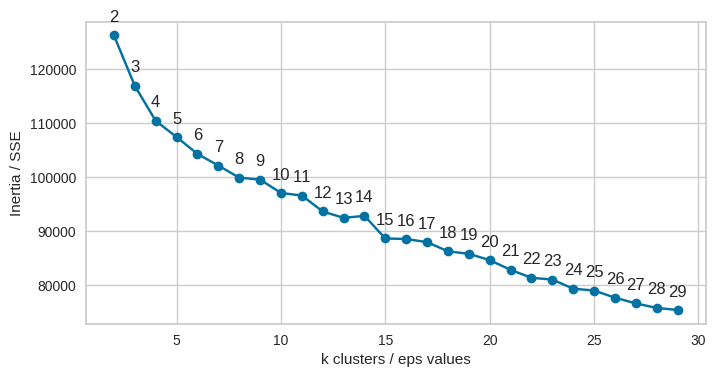

(519, 7) (76, 3) (188, 3) (76, 3) (264, 5) (264, 4)
(40, 105) (184, 105) (40, 105)
Running model  kmeans  with embedding  glove


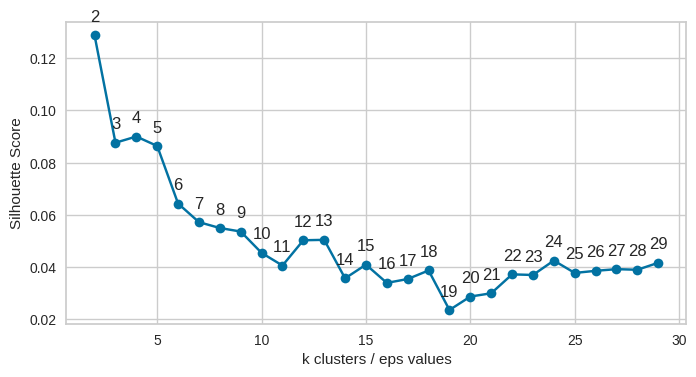

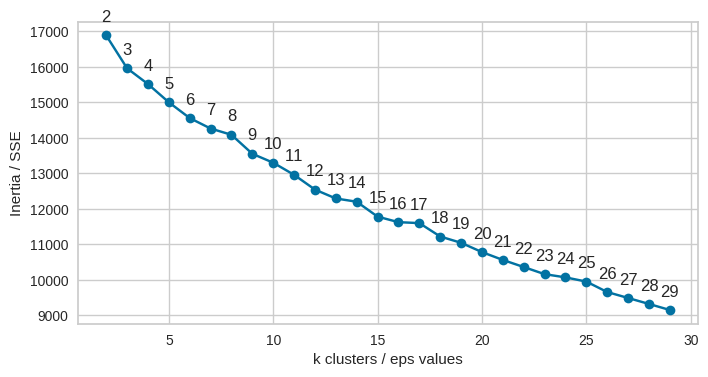

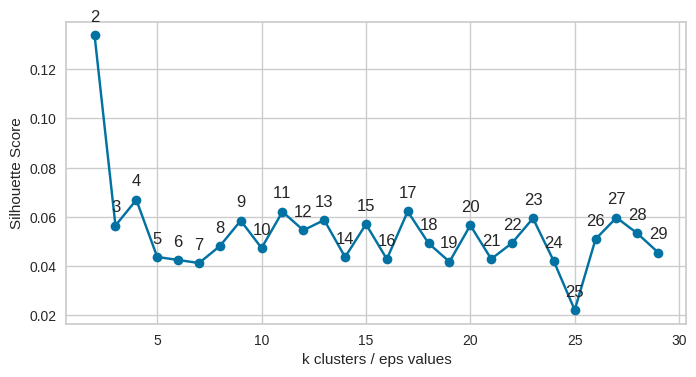

In [36]:
[df_train_kmeans_cls, df_dev_kmeans_cls, df_test_kmeans_cls], label_list_kmeans_cls, model_list_kmeans_cls, X_kmeans_cls, pca_model_kmeans_cls = evaluate_models(df1_pers, df2_pers, df_splits, 'bert', 'kmeans', iter_vals=np.arange(2, 30), min_samples=5, pca=False, n=3)
[df_train_kmeans_glove, df_dev_kmeans_glove, df_test_kmeans_glove], label_list_kmeans_glove, model_list_kmeans_glove, X_kmeans_glove, pca_model_kmeans_glove = evaluate_models(df1_pers, df2_pers, df_splits, 'glove', 'kmeans', iter_vals=np.arange(2, 30), min_samples=5, pca=False, n=3)

### Run: Kmeans with PCA
n=3
* **BERT: k=5, silhouette score=0.405**
* GloVe: k=2, silhouette score=0.345 (k=7, sil=0.295)

n=5
* BERT: k=4, silhouette score=0.28
* GloVe: k=2, silhouette score=0.28 

PCA n=3

(519, 7) (76, 3) (188, 3) (76, 3) (264, 5) (264, 4)
Index(['Unnamed: 0', 'film', 'character', 'set', 'personality'], dtype='object')
(40, 773) (184, 773) (40, 773)
Running model  kmeans  with embedding  bert
PCA(n_components=3)


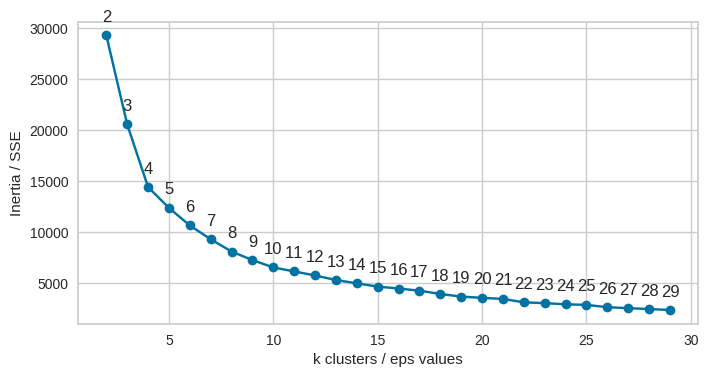

(519, 7) (76, 3) (188, 3) (76, 3) (264, 5) (264, 4)
(40, 105) (184, 105) (40, 105)
Running model  kmeans  with embedding  glove
PCA(n_components=3)


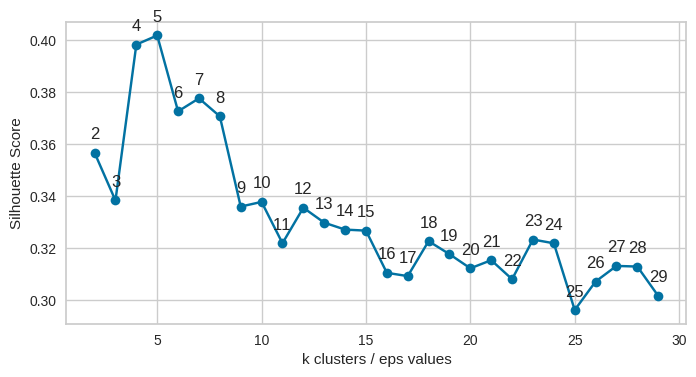

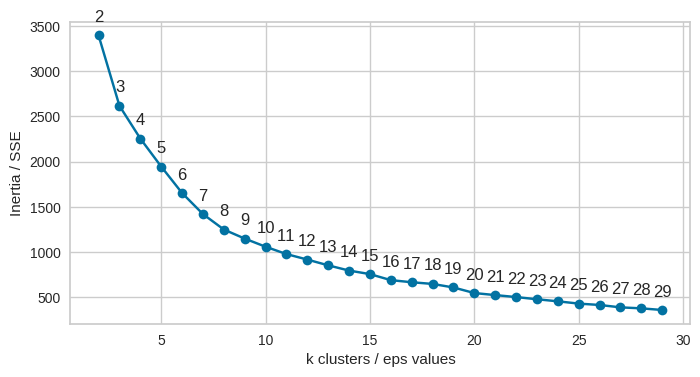

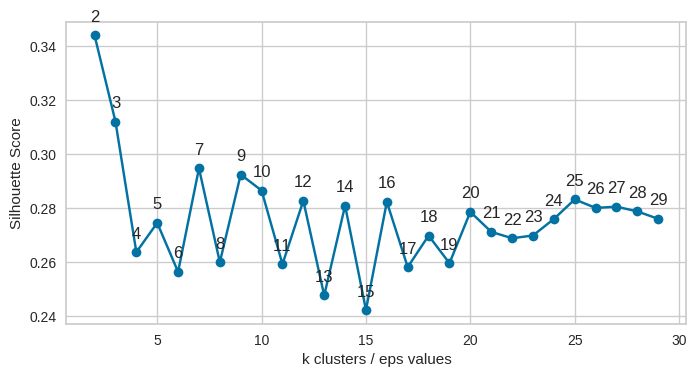

In [37]:
[df_train_kmeans_cls_pca, df_dev_kmeans_cls_pca, df_test_kmeans_cls_pca], label_list_kmeans_cls_pca, model_list_kmeans_cls_pca, X_kmeans_cls_pca, pca_model_kmeans_cls_pca = evaluate_models(df1_pers, df2_pers, df_splits, 'bert', 'kmeans', iter_vals=np.arange(2, 30), min_samples=5, pca=True, n=3)
[df_train_kmeans_glove_pca, df_dev_kmeans_glove_pca, df_test_kmeans_glove_pca], label_list_kmeans_glove_pca, model_list_kmeans_glove_pca, X_kmeans_glove_pca, pca_model_kmeans_glove_pca = evaluate_models(df1_pers, df2_pers, df_splits, 'glove', 'kmeans', iter_vals=np.arange(2, 30), min_samples=5, pca=True, n=3)

PCA n=5

(519, 7) (76, 3) (188, 3) (76, 3) (264, 5) (264, 4)
Index(['Unnamed: 0', 'film', 'character', 'set', 'personality'], dtype='object')
(40, 773) (184, 773) (40, 773)
Running model  kmeans  with embedding  bert
PCA(n_components=5)


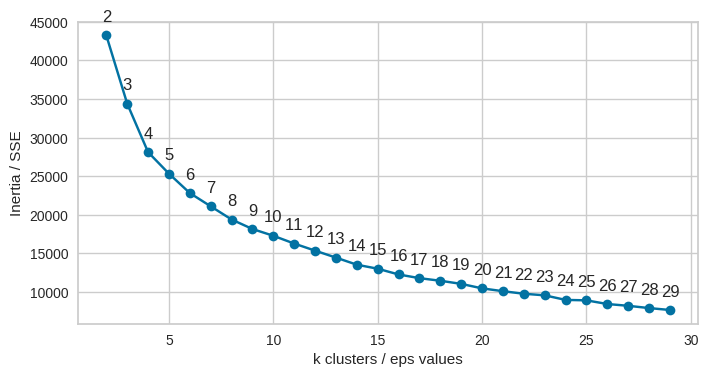

(519, 7) (76, 3) (188, 3) (76, 3) (264, 5) (264, 4)
(40, 105) (184, 105) (40, 105)
Running model  kmeans  with embedding  glove
PCA(n_components=5)


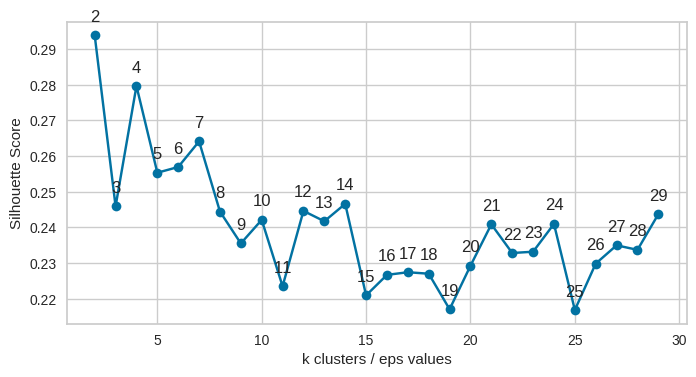

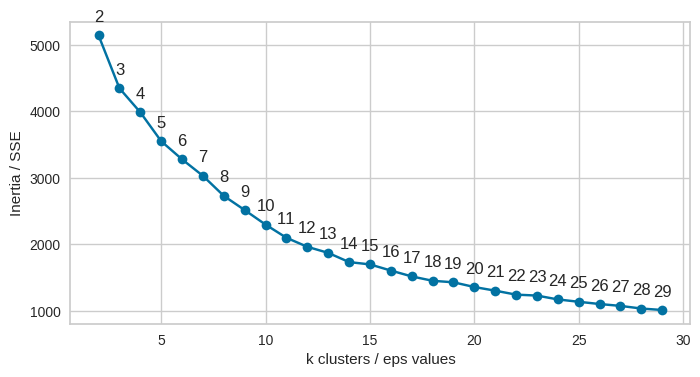

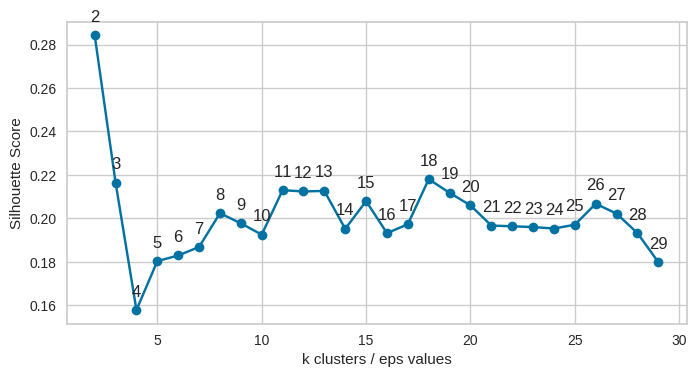

In [38]:
[df_train_kmeans_cls_pca5, df_dev_kmeans_cls_pca5, df_test_kmeans_cls_pca5], label_list_kmeans_cls_pca5, model_list_kmeans_cls_pca5, X_kmeans_cls_pca5, pca_model_kmeans_cls_pca5 = evaluate_models(df1_pers, df2_pers, df_splits, 'bert', 'kmeans', iter_vals=np.arange(2, 30), min_samples=5, pca=True, n=5)
[df_train_kmeans_glove_pca5, df_dev_kmeans_glove_pca5, df_test_kmeans_glove_pca5], label_list_kmeans_glove_pca5, model_list_kmeans_glove_pca5, X_kmeans_glove_pca5, pca_model_kmeans_glove_pca5 = evaluate_models(df1_pers, df2_pers, df_splits, 'glove', 'kmeans', iter_vals=np.arange(2, 30), min_samples=5, pca=True, n=5)

### Run: DBSCAN without PCA
* BERT: e=7, silhouette score=0.48, clusters #=2
* GloVe: e=4, silhouette score=0.43, clusters #=2

In [ ]:
iter_vals = np.array((4, 5, 6, 7, 8, 9))
[df_train_db_cls, df_dev_db_cls, df_test_db_cls], label_list_db_cls, model_list_db_cls, X_db_cls, pca_model_db_cls = evaluate_models(df1_pers, df2_pers, df_splits, 'bert', 'dbscan', iter_vals=iter_vals, min_samples=3, pca=False, n=3)
iter_vals = np.array((2, 3, 4))
[df_train_db_glove, df_dev_db_glove, df_test_db_glove], label_list_db_glove, model_list_db_glove, X_db_glove, pca_model_db_glove = evaluate_models(df1_pers, df2_pers, df_splits, 'glove', 'dbscan', iter_vals=iter_vals, min_samples=3, pca=False, n=3)

### Run: DBSCAN with PCA

**n=3**
By max silhouette score
* BERT: e=11, silhouette score=0.47, clusters #=2
* GloVe: e=6, silhouette score=0.58, clusters #=2

By max cluster
* BERT: clusters #=4, e=5.75, silhouette score=0.23
* **GloVe: clusters #=3, e=5, silhouette score=0.52** 

**n=5**
By max silhouette score
* BERT: e=13, silhouette score=0.495, clusters #=2
* *GloVe: e=11, silhouette score=0.605, clusters #=2*

By max cluster
* BERT: clusters #=4, e=9, silhouette score=0.19
* GloVe: clusters #=3, e=6, silhouette score=0.45

#### PCA n=3

In [ ]:
iter_vals = np.array((2, 3, 4, 5, 5.25, 5.5, 5.75, 6))
[df_train_db_cls_pca, df_dev_db_cls_pca, df_test_db_cls_pca], label_list_db_cls_pca, model_list_db_cls_pca, X_db_cls_pca, pca_model_db_cls_pca = evaluate_models(df1_pers, df2_pers, df_splits, 'bert', 'dbscan', iter_vals=iter_vals, min_samples=3, pca=True, n=3)
iter_vals = np.array((2, 3, 4, 5, 6, 7))
[df_train_db_glove_pca, df_dev_db_glove_pca, df_test_db_glove_pca], label_list_db_glove_pca, model_list_db_glove_pca, X_db_glove_pcap, ca_model_db_glove_pca = evaluate_models(df1_pers, df2_pers, df_splits, 'glove', 'dbscan', iter_vals=iter_vals, min_samples=3, pca=True, n=3)

#### PCA n=5

In [ ]:
iter_vals = np.array((6, 7, 8, 9, 10, 11, 12, 13, 14, 15))
[df_train_db_cls_pca5, df_dev_db_cls_pca5, df_test_db_cls_pca5], label_list_db_cls_pca5, model_list_db_cls_pca5, X_db_cls_pca5, pca_model_db_cls_pca5 = evaluate_models(df1_pers, df2_pers, df_splits, 'bert', 'dbscan', iter_vals=iter_vals, min_samples=3, pca=True, n=5)
iter_vals = np.array((6, 7, 8, 9, 10, 11, 12, 13))
[df_train_db_glove_pca5, df_dev_db_glove_pca5, df_test_db_glove_pca5], label_list_db_glove_pca5, model_list_db_glove_pca5, X_db_glove_pca5, pca_model_db_glove_pca5 = evaluate_models(df1_pers, df2_pers, df_splits, 'glove', 'dbscan', iter_vals=iter_vals, min_samples=3, pca=True, n=5)

## Model selection



#### Visualize final selected models

KMEANS WINNER: Bert with PCA n=3, 5 clusters
DBSCAN WINNER: GloVe with PCA n=3, 3 clusters, e=5 (3)


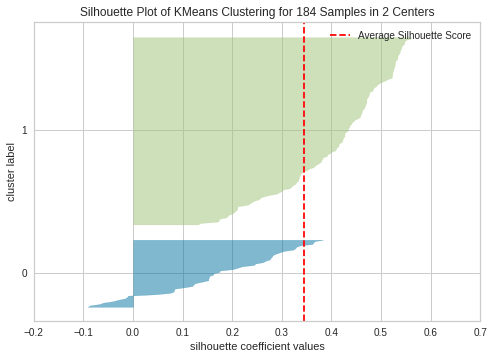

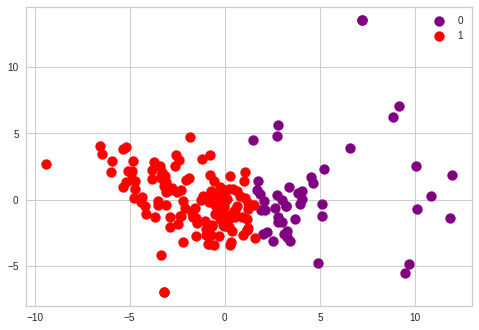

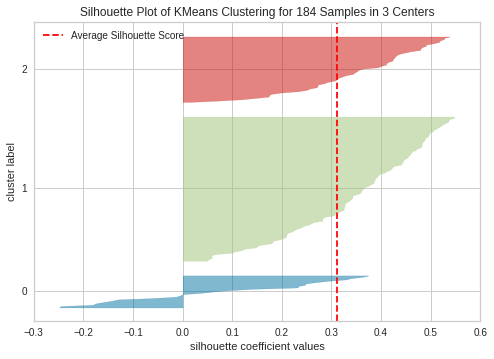

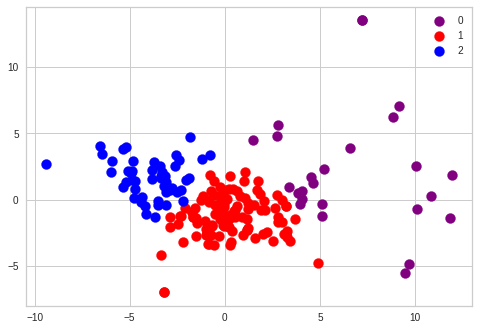

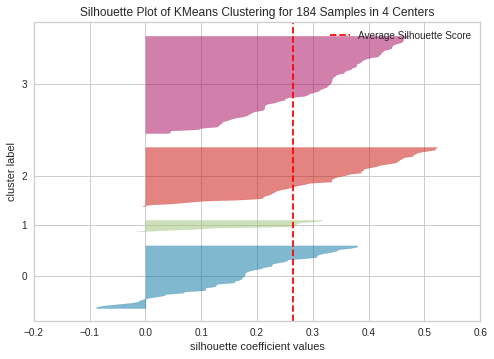

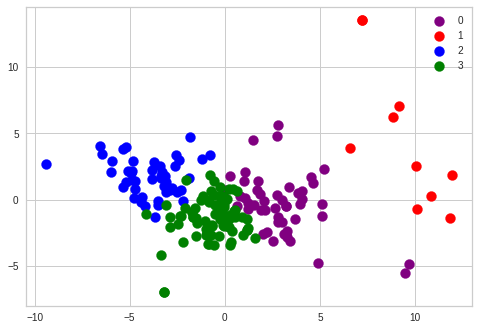

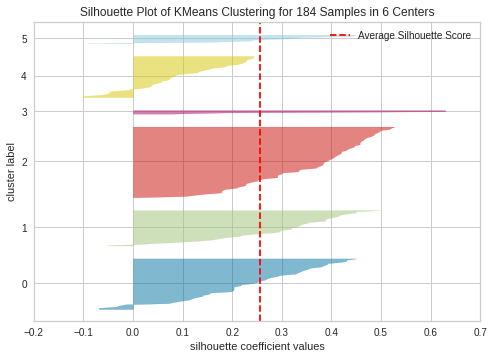

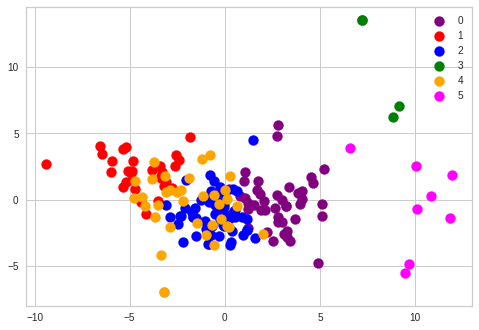

DBSCAN OVERALL WINNER: GloVe with PCA n=5, 2 clusters, e=11 (5)


In [52]:
# Show winner plot from Kmean: Bert with PCA n=3
print("KMEANS WINNER: Bert with PCA n=3, 5 clusters")
k_inspect_vals = np.array((2, 3, 4, 5))
#visualize_silhouette_plots(k_inspect_vals-2, model_list=model_list_kmeans_cls_pca, X=X_kmeans_cls_pca, label_list=label_list_kmeans_cls_pca)


# Show winner of DBSCAN: GloVe with PCA n=3 (clusters #=3, e=5, silhouette score=0.52)
print("DBSCAN WINNER: GloVe with PCA n=3, 3 clusters, e=5 (3)")
#draw_cluster_plot(X=X_db_glove_pca, label_list=label_list_db_glove_pca[3])

# Show winner of GloVe: Kmeans with PCA n=3 (clusters #=7, silhouette score=0.295)
k_inspect_vals = np.array((2, 3, 4, 6))
visualize_silhouette_plots(k_inspect_vals-2, model_list=model_list_kmeans_glove_pca, X=X_kmeans_glove_pca, label_list=label_list_kmeans_glove_pca)


# Show winner with highest Silhouette score overall (only 2 clusters): GloVe with PCA n=5 (clusters #=2, e=11, silhouette score=0.58)
print("DBSCAN OVERALL WINNER: GloVe with PCA n=5, 2 clusters, e=11 (5)")
#draw_cluster_plot(X=X_db_glove_pca5, label_list=label_list_db_glove_pca5[5])

### Calculate final clusters

In [53]:
def calc_and_eval_final_cluster(df_train_in, df_dev_in, df_test_in, model_list, label_list, pca_model, n, pca=False):
  df_train = df_train_in.copy()
  df_dev = df_dev_in.copy()
  df_test = df_test_in.copy()

  # Get final model
  train_model = model_list[n-2]

  # Get train predicted labels & append to df
  train_labels = label_list[n-2]
  df_train['k' + str(n) + '_pred_label'] = train_labels

  # Get dev predicted labels & append to df
  dev_labels, dev_sil_score, X_dev =  run_final_kmeans(model=train_model, df=df_dev, pca_model=pca_model, pca=pca)
  df_dev['k' + str(n) + '_pred_label'] = dev_labels
  print("Dev set silhouette score: ", dev_sil_score)

  # Visualize dev set
  draw_cluster_plot(label_list=dev_labels, X=X_dev)
  visualizer = SilhouetteVisualizer(train_model, colors='yellowbrick')
  visualizer.fit(X_dev)        
  visualizer.show() 

  # Get test predicted labels & append to df
  test_labels, test_sil_score, X_test =  run_final_kmeans(model=train_model, df=df_test, pca_model=pca_model, pca=pca)
  df_test['k' + str(n) + '_pred_label'] = test_labels
  #print("Test set silhouette score: ", test_sil_score)

  # Concat all sets
  df_final = pd.concat([df_dev, df_train])
  df_final = pd.concat([df_final, df_test])
  return df_final




[PCA(n_components=3)]
Dev set silhouette score:  0.14845473398304118


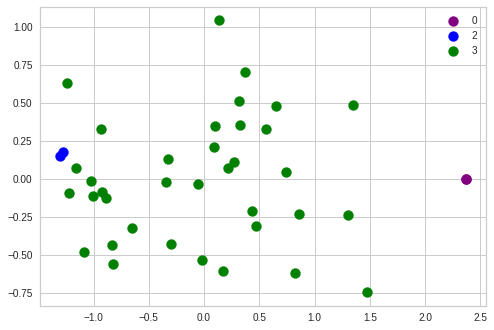

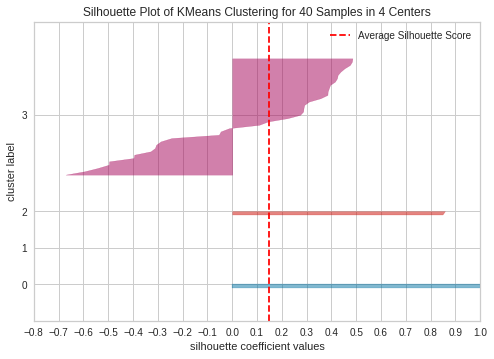

[PCA(n_components=3)]


,Unnamed: 0,film,character,set,personality,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,k4_pred_label
185,65,unforgiven.txt,MUNNY,dev,"Personality… dependable and solid, but also ru...",-0.184111,0.285895,0.183146,-0.309397,-0.063436,0.046447,-0.036523,-0.023228,-0.182943,0.083481,0.056612,-0.217377,0.378120,0.055114,0.171462,-0.055599,0.214986,-0.193588,-0.091829,0.267202,0.370732,-0.124712,0.087855,0.068398,0.274217,0.174633,-0.148356,-0.387253,0.015972,-0.131959,-0.016547,0.412764,-0.241706,-0.010022,0.170587,...,0.360091,-0.252877,0.433511,0.737709,-0.132947,0.511572,0.273725,0.282751,-0.398241,0.104175,-0.242376,0.028248,-0.258771,0.281582,-0.160410,-0.389932,0.015636,-0.476089,0.030315,0.689641,0.444636,-0.556198,0.231180,-1.205051,-0.158903,0.207140,0.211407,-0.270240,-0.263711,-0.051164,-0.239072,-0.128353,0.329013,-0.434049,-0.155866,-0.302107,-0.501973,0.452737,0.252473,3
186,112,rush_hour.txt,CARTER,dev,"Personality… loud, brash, and proud. James Car...",-0.102339,0.026858,0.294490,-0.709673,-0.310898,0.582220,-0.471883,0.073798,-0.246648,0.168342,0.101999,-0.298447,-0.041810,-0.037337,-0.002415,-0.306352,-0.216242,-0.072547,-0.019450,0.347439,0.278540,0.245913,0.132490,-0.369637,0.251832,0.265632,-0.459525,0.215662,0.400189,-0.031683,-0.234635,0.516340,0.274343,0.131515,0.109107,...,0.526064,-0.397540,0.007465,0.468650,-0.345765,0.816562,0.183430,0.201543,-0.270925,0.320530,-0.183263,-0.215680,-0.493620,0.131470,0.265352,-0.069507,-0.115497,-0.427508,-0.407558,0.495283,-0.285269,0.008039,0.189313,-1.023438,-0.447665,-0.257519,-0.019499,-0.295810,-0.457545,0.410739,-0.190840,-0.212157,0.260053,-0.587270,0.151088,-1.094837,-0.418588,0.098813,0.406424,3
187,10,friday_the_13th_part_10_jason_x.txt,JASON,dev,"Personality… none. Jason is a blank, murderous...",0.110000,0.639050,0.629090,-0.367510,-0.142840,0.089884,0.415240,-0.106620,0.058022,-0.059897,0.806030,0.401130,0.430970,0.206390,0.119220,-0.487400,-0.520070,0.325790,-0.692020,0.714860,0.276830,-0.111870,-0.239970,-0.667100,-0.348370,-0.368110,0.007915,-0.504950,0.034063,-0.414850,0.587560,0.205940,-0.189920,-0.146590,0.518450,...,0.948440,-0.429430,0.022248,0.549010,0.057680,0.465060,0.140510,-0.220120,-0.011954,-0.205340,-0.006800,0.092135,0.157760,0.714520,0.505430,-0.056508,-0.458330,-0.941740,0.042119,0.149320,-0.167930,-0.216380,-0.189680,-1.679100,-0.296480,0.097156,-0.049748,-0.177710,0.237970,0.075057,-0.485540,-0.113240,-0.137820,-0.765700,0.342250,-0.802050,0.071331,0.177580,0.040309,2
188,95,the_majestic.txt,PETE,dev,"Personality… ambitious, proud, and talented, a...",0.031873,0.079612,0.152060,-0.042764,-0.146232,0.255417,-0.141793,0.179233,-0.310922,0.232510,0.062465,-0.083747,0.214920,-0.226948,0.090528,-0.381319,0.232012,0.011945,-0.350108,0.487012,0.170336,-0.081659,0.008516,-0.019711,0.194883,-0.108929,-0.158816,-0.349007,0.276008,-0.079658,-0.288144,0.526254,0.148147,-0.016916,-0.144648,...,0.744940,-0.199474,0.142816,0.499401,-0.339206,0.385486,0.380236,0.226000,-0.197684,0.083866,-0.149662,-0.187078,-0.357590,0.103762,0.071568,-0.203227,-0.005999,-0.737442,-0.200521,0.586472,0.346302,-0.225411,0.064898,-1.104884,-0.158802,0.079187,0.071554,-0.369851,-0.352962,-0.065048,-0.008199,0.078687,0.188575,-0.563341,-0.015165,-0.353575,-0.256577,0.306847,0.086793,3
189,159,almost_famous.txt,WILLIAM,dev,"Personality… bright and ambitious, but still n...",-0.094517,0.301048,0.190110,-0.237933,0.088387,0.140383,-0.075840,-0.035833,0.048045,0.137332,0.072506,-0.049423,0.271255,-0.204493,0.144420,-0.214870,-0.020302,0.051125,0.144040,0.194398,0.020123,-0.021085,0.208229,-0.079661,0.219478,0.243062,-0.114729,-0.398255,-0.322716,-0.288351,-0.326019,0.431733,-0.140249,-0.065028,0.096620,...,0.720520,-0.459652,0.204696,0.640552,-0.268703,0.536730,0.353702,0.171737,-0.489307,0.352324,-0.352177,-

In [60]:
df_final = calc_and_eval_final_cluster(df_train_kmeans_glove_pca, df_dev_kmeans_glove_pca, df_test_kmeans_glove_pca, model_list_kmeans_glove_pca, label_list_kmeans_glove_pca, pca_model_kmeans_glove_pca, n=4, pca=True)
df_final



### Write CSV

In [61]:
# STEP INBETWEEN - write csv 
df_final.to_csv('/content/drive/MyDrive/Berkeley/INFO256/data/results/synth_gold_kmeans_glove_pca_v03.csv', encoding='utf-8-sig')

### Other


In [159]:
print(np.linspace(0, 10, 30).shape)

(30,)


In [139]:
a = np.array((2, 3, 4, 4, 4, 4, 5, 6))

np.shape(np.unique(a, return_counts=False))[0]

5

In [ ]:
# Preprocess
df_all = preprocess_long(df1, df2, df_split)

# BERT embedding
df_cls = get_cls_token_for_df(model, df_all)
df_cls

# GloVe embedding
df_glove = get_glove_token_for_df(df_all)
#df_glove

# Break up into train, dev, test
df_train_cls, df_dev_cls, df_test_cls = get_train_dev_test(df_cls)
print(df_dev_cls.shape, df_train_cls.shape, df_test_cls.shape)

# Run clustering with different k: df_dev
k_vals_cls = np.arange(2, 30)
klabel_list_cls, kmean_model_list_cls, X_cls = evaluate_kmeans_for_k(k_vals_cls, df_train_cls)

print('-------------------')

# GloVe embedding
# Break up into train, dev, test
df_train_glove, df_dev_glove, df_test_glove = get_train_dev_test(df_glove)
print(df_dev_glove.shape, df_train_glove.shape, df_test_glove.shape)

# Run clustering with different k: df_dev
k_vals_glove = np.arange(2, 30)
klabel_list_glove, kmean_model_list_glove, X_glove = evaluate_kmeans_for_k(k_vals_glove, df_train_glove)

NameError: ignored